# <div style="color:rgb(200,180,180);font-size:42px;"><u>***UCI Breast Cancer Pipeline Project***</u></div>
## **Some additional variable information from UCI:**

1 )  ID number <br>
2 )  Diagnosis (M = malignant, B = benign) <br>

3-32 ) Below &#8595;

### **Ten real-valued features are computed for each cell nucleus:**

1) radius (mean of distances from center to points on the perimeter)
2) texture (standard deviation of gray-scale values)
3) perimeter
4) area
5) smoothness (local variation in radius lengths)
6) compactness (perimeter^2 / area - 1.0)
7) concavity (severity of concave portions on the contour)
8) concave points (number of concave portions of the contour)
9) symmetry
10) fractal dimension ("coastline approximation" - 1)
###


## 0. Import Modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from imblearn.over_sampling import SMOTE

## 1. Import UCI Dataset &#8594; Write Dataset to Local CSV

In [2]:
## Import UCI Dataset and write to local csv
## NOTE: Commented out code for the sake of minimizing runtime, it is functional/reusable.
"""
from ucimlrepo import fetch_ucirepo
breast_ca = fetch_ucirepo(id=17)

breast_ca_df = breast_ca.data.original
breast_ca_df.to_csv('UCI_BreastCancer.csv', index=False)
print('Successfully wrote dataset to csv file!')
"""

# Read csv and store as df
df = pd.read_csv('UCI_BreastCancer.csv')

## 2. Search for missing values and verify shape &#8594; Identify Feature Types

In [3]:
# Search Dataset for missing / null values:
print('\n')
try:
    if df.isnull().sum().any()>0:
        print('NaN values found: ', df.isnull().sum())
    else:
        print('No NaN or null values found')
except Exception as e:
    print(e)

# Consider the number of unique values for each feature:
# All features are numeric.
# print(df.nunique())

# Verify features and shape:
print('\nDATASET COLUMNS: \n',df.columns)
print('\nDATASET SHAPE:  ',df.shape)



No NaN or null values found

DATASET COLUMNS: 
 Index(['ID', 'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3', 'Diagnosis'],
      dtype='object')

DATASET SHAPE:   (569, 32)


## 3. Define Target (y) and Features (X) &#8594; Convert Target to Binary &#8594; Train_Test_Split()

In [4]:
# Define features and target
y = df.Diagnosis
X = df.drop(columns=['Diagnosis','ID'])

print('\n')
# Verify expected shapes before and after:
print('X shape: ',X.shape)
print('y shape: ',y.shape)

# Convert target data to binary and verify value_counts.
print('\nTarget values: Benign (B) and Malignant (M)')
print('Target prior to binary conversion: \n',y.value_counts())
try:
    y = pd.DataFrame(np.where(y == 'M',1,0), columns=['Diagnosis'])
    y = y.Diagnosis
    print('\nTarget post binary conversion: \n',y.value_counts(),'\n')

except Exception as e:
    print(e)

# Verify expected shapes before and after:
print('X shape: ',X.shape)
print('y shape: ',y.shape)

# train_test_split (random_state=13)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)



X shape:  (569, 30)
y shape:  (569,)

Target values: Benign (B) and Malignant (M)
Target prior to binary conversion: 
 Diagnosis
B    357
M    212
Name: count, dtype: int64

Target post binary conversion: 
 Diagnosis
0    357
1    212
Name: count, dtype: int64 

X shape:  (569, 30)
y shape:  (569,)


## 4. Lasso and LDA &#8594; Exploratory Data Analysis and Feature Selection

In [5]:
# Summary of findings:
print('\n')
print('Lasso L1 Regularization outperforms '
      'Linear Discriminant Analysis (LDA) for feature selection performance.')

from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# LASSO feature set:
reg = Lasso(alpha=0.005)
reg.fit(X_train_scale,y_train)
X_train_scale = pd.DataFrame(X_train_scale,columns=X.columns)
X_L_train = X_train_scale[X_train_scale.columns[np.abs(reg.coef_) > 0.001]]
X_test_scale = pd.DataFrame(X_test_scale,columns=X.columns)
X_L_test = X_test_scale[X_test_scale.columns[np.abs(reg.coef_) > 0.001]]
print('X_L_train shape: \t',X_L_train.shape)

# LDA feature set:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)
X_LDA_train = X_train_scale[X_train_scale.columns[np.abs(clf.coef_[0]) > 0.7]]
X_LDA_test = X_test_scale[X_test_scale.columns[np.abs(clf.coef_[0]) > 0.7]]
print('X_LDA_train shape:\t',X_LDA_train.shape)

# Comparing selected features:
s_lasso = pd.Series(X_L_train.columns,name='Lasso Features').sort_values()
s_lda = pd.Series(X_LDA_train.columns,name='LDA Features').sort_values()
s_lasso = pd.Series(s_lasso.values,name='Lasso Features')
s_lda = pd.Series(s_lda.values,name='LDA Features')
featureset_compare = pd.concat([s_lasso,s_lda],axis=1)
print(f'\n{featureset_compare}')


# For loop to compare Lasso and LDA findings:
score_list = list()
for i in range(1,51):
    # Lasso features on SGDClassifier:
    clf_validate = SGDClassifier(random_state=i+1,penalty='l2',alpha=0.01,loss='log_loss')
    clf_validate.fit(X_L_train,y_train)
    lasso_score = clf_validate.score(X_L_test,y_test)
    # LDA features on SGDClassifier:
    clf_validate.fit(X_LDA_train,y_train)
    lda_score = clf_validate.score(X_LDA_test,y_test)
    # Append:
    score_list.append([i+1,lasso_score,lda_score])

# Comparing results from loop:
print('\nAvg results from fitting SGDC with Lasso and LDA feature sets (50 times): ',)
c_names = ['random_state','lasso_score','lda_score']
scores_df = pd.DataFrame(score_list,columns=c_names)
print(f'Lasso Avg Score: \t{scores_df["lasso_score"].mean():.4f}')
print(f'LDA Avg Score: \t\t{scores_df["lda_score"].mean():.4f}')
print(f'Lasso Std Dev: \t\t{scores_df["lasso_score"].std():.4f}')
print(f'LDA Std Dev: \t\t{scores_df["lda_score"].std():.4f}')




Lasso L1 Regularization outperforms Linear Discriminant Analysis (LDA) for feature selection performance.
X_L_train shape: 	 (455, 19)
X_LDA_train shape:	 (455, 19)

        Lasso Features        LDA Features
0                area2               area1
1         compactness1               area2
2         compactness2               area3
3      concave_points1        compactness1
4      concave_points2     concave_points1
5      concave_points3     concave_points2
6           concavity2     concave_points3
7           concavity3          concavity1
8   fractal_dimension1          concavity2
9   fractal_dimension3          concavity3
10             radius2  fractal_dimension1
11             radius3  fractal_dimension3
12         smoothness2          perimeter1
13         smoothness3          perimeter3
14           symmetry2             radius1
15           symmetry3             radius2
16            texture1             radius3
17            texture2         smoothness2
18            t

## 4.1. Lasso L1 Regularization



Lasso(alpha=0.0005) score:	 0.725 		# of features w/ coef!=0 :  26
Lasso(alpha=0.002) score:	 0.730 		# of features w/ coef!=0 :  24
Lasso(alpha=0.005) score:	 0.718 		# of features w/ coef!=0 :  19
Lasso(alpha=0.05) score:	 0.666 		# of features w/ coef!=0 :  5

Best score: 
0.730


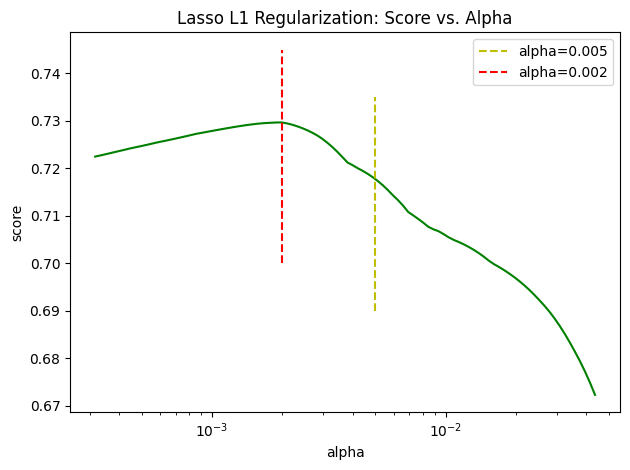

<Figure size 640x480 with 0 Axes>

In [6]:
# Initialize scaler and fit_transform:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

print('\n')
# Loop to show scores and number of features with non-zero coefficients:
show_list = [0.0005,0.002,0.005,0.05]
for i in show_list:
    reg = Lasso(alpha=i)
    reg.fit(X_train_scale,y_train)
    coefs = pd.Series(reg.coef_,X.columns)
    print(f'Lasso(alpha={i}) score:\t',f'{reg.score(X_test_scale, y_test):.3f}',
          '\t\t# of features w/ coef!=0 : ', coefs[reg.coef_ != 0].shape[0])

# Loop to analyze for any meaningful impact of alpha on the score:
score_list = list()
try:
    for i in np.logspace(-3.5,-1.36,100):
        reg = Lasso(alpha=i)
        reg.fit(X_train_scale,y_train)
        coefs = pd.Series(reg.coef_,X.columns)
        score_list.append([i,reg.score(X_test_scale, y_test)])
except Exception as e:
    print(e)

c_names = ['alpha:','score:']
score_df = pd.DataFrame(score_list,columns=c_names)
max_score = score_df['score:'].max()
print(f'\nBest score: \n{max_score:.3f}')

plt.plot(score_df['alpha:'],score_df['score:'],color='green',scalex=True)
plt.plot([0.005,0.005],[0.69,0.735],color='y',linestyle='--',label='alpha=0.005')
plt.plot([0.002,0.002],[0.70,0.745],color='red',linestyle='--',label='alpha=0.002')
plt.legend()
plt.xlabel('alpha')
plt.xscale('log')
plt.ylabel('score')
plt.title('Lasso L1 Regularization: Score vs. Alpha')
plt.tight_layout()
plt.show()
plt.clf()

## 4.1.1. Lasso L1 Regularization - Coefficients

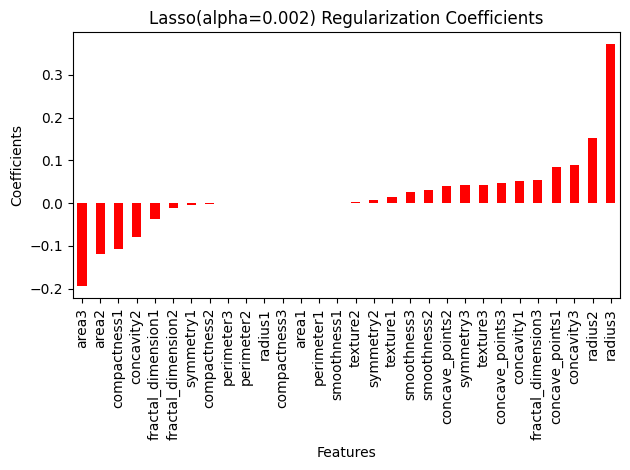

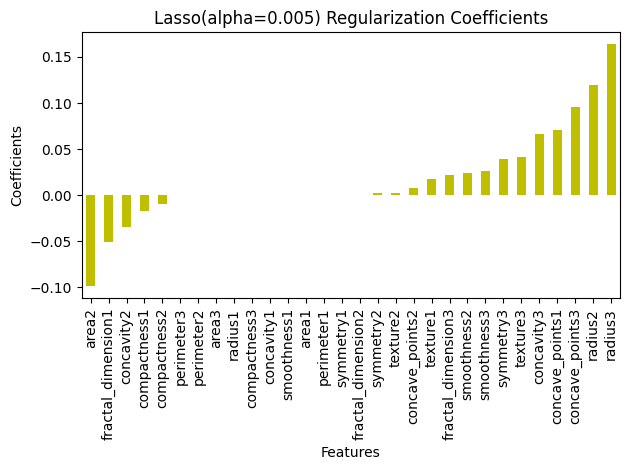

<Figure size 640x480 with 0 Axes>

In [7]:
# Supporting visuals for Lasso L1 Regularization tuning of alpha:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
print('\n')
# Plot of alpha=0.002 (RED)
reg = Lasso(alpha=0.002)
reg.fit(X_train_scale,y_train)
coefs = pd.Series(reg.coef_,X.columns).sort_values()
coefs.plot(kind='bar',color='red')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso(alpha=0.002) Regularization Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.clf()

print('\n')
# Plot of alpha=0.005 (YELLOW)
reg = Lasso(alpha=0.005)
reg.fit(X_train_scale,y_train)
coefs = pd.Series(reg.coef_,X.columns).sort_values()
coefs.plot(kind='bar',color='y')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso(alpha=0.005) Regularization Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.clf()


## 4.1.2. Lasso L1 Regularization - Feature Selection
*Note: Defining new Lasso features training / testing sets as* **X_L_train** *and* **X_L_test**

In [8]:
# Using alpha=0.005 (19 features with non-zero coefficients)

# Ensure a known starting condition before fitting Lasso:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Fit Lasso with alpha=0.005:
reg = Lasso(alpha=0.005)
reg.fit(X_train_scale,y_train)

# Select features with coefficients > 0.001:
X_train_scale = pd.DataFrame(X_train_scale,columns=X.columns)
X_L_train = X_train_scale[X_train_scale.columns[np.abs(reg.coef_) > 0.001]]

X_test_scale = pd.DataFrame(X_test_scale,columns=X.columns)
X_L_test = X_test_scale[X_test_scale.columns[np.abs(reg.coef_) > 0.001]]

## DON'T Fall for this trap!
# X_L_test = X_test_scale[X_test_scale.columns[coefs.abs() > 0.001]]
## Using coefs.abs() will produce incorrect features due to the sort_values() called on it.
print('\n')
# Verify expected shapes (19 features):
print('X_L_train (Lasso features) shape: \t',X_L_train.shape)
print('X_L_test (Lasso features) shape: \t',X_L_test.shape)

# Verify expected columns:
# print(X_L_train.columns)



X_L_train (Lasso features) shape: 	 (455, 19)
X_L_test (Lasso features) shape: 	 (114, 19)


## 4.1.3. Lasso L1 Regularization – Validating Feature Selection with RFC

In [9]:
# Compare the performance of RandomForestClassifier on X_L_train and X_L_test VS full feature set.

# Loop to fit RFC with Lasso features and the Full feature set, 50 times:
# About 15 sec runtime with 50 loop runs.
rfc_list = list()
for i in range(1,51):
    # LASSO FEATURE SET:
    clf_validate1 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate1.fit(X_L_train,y_train)
    lasso_score = clf_validate1.score(X_L_test,y_test)
    # FULL FEATURE SET:
    clf_validate2 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND
    rfc_list.append([i+1,lasso_score,full_score])

print('\n')
c_names = ['random_state','lasso_score','full_score']
scores_df = pd.DataFrame(rfc_list,columns=c_names)
print(f'RFC Lasso Avg Score: \t{scores_df["lasso_score"].mean():.4f}')
print(f'RFC Full Avg Score: \t{scores_df["full_score"].mean():.4f}')
print(f'RFC Lasso Std Dev: \t{scores_df["lasso_score"].std():.4f}')
print(f'RFC Full Std Dev: \t{scores_df["full_score"].std():.4f}')

# LASSO feature set has a BIG improved average score and a lower std dev!
# While using only 19 of the 30 features!



RFC Lasso Avg Score: 	0.9698
RFC Full Avg Score: 	0.9225
RFC Lasso Std Dev: 	0.0087
RFC Full Std Dev: 	0.0105


## 4.1.4. Lasso L1 Regularization – Validating Feature Selection with SGDClassifier

In [10]:
# Compare the performance of SGDClassifier on X_L_train and X_L_test VS full feature set.
from sklearn.linear_model import SGDClassifier

# Loop to fit SGDClassifier with Lasso features and the Full feature set, 50 times:
# About 0.3 sec runtime with 50 loop runs.
sgd_list = list()
for i in range(1,51):
    # LASSO FEATURE SET:
    clf_validate1 = SGDClassifier(random_state=i+1,penalty='l2',alpha=0.01,loss='log_loss')
    clf_validate1.fit(X_L_train,y_train)
    lasso_score = clf_validate1.score(X_L_test,y_test)
    # FULL FEATURE SET:
    clf_validate2 = SGDClassifier(random_state=i+1,penalty='l2',alpha=0.01,loss='log_loss')
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND RESULTS
    sgd_list.append([i+1,lasso_score,full_score])

print('\n')
c_names = ['random_state','lasso_score','full_score']
scores_df = pd.DataFrame(sgd_list,columns=c_names)
print(f'SGDC Lasso Avg Score: \t{scores_df["lasso_score"].mean():.4f}')
print(f'SGDC Full Avg Score: \t{scores_df["full_score"].mean():.4f}')
print(f'SGDC Lasso Std Dev: \t{scores_df["lasso_score"].std():.4f}')
print(f'SGDC Full Std Dev: \t{scores_df["full_score"].std():.4f}')

# LASSO feature set has a slightly improved average score and a similar std dev!
# While using only 19 of the 30 features!



SGDC Lasso Avg Score: 	0.9909
SGDC Full Avg Score: 	0.9889
SGDC Lasso Std Dev: 	0.0017
SGDC Full Std Dev: 	0.0053


## 4.1.5. Lasso L1 Regularization – Tuning alpha
*NOTE: Lasso (alpha=0.005) features set performs best when tested with SGDC and will continue to be used*
- The boost in performance from dropping 5 features {24 (a=0.002) to 19 (a=0.005)}
is likely due to the removal of noisy features.
- The 0.3% reduction in average score when using only 9 features (a=0.020) vs. 19 features (a=0.005)
is impressive!
- Also of note, 5 features and 24 features achieved the same accuracy score! Those are important features!

In [11]:
print('\n')
print('Comparing Lasso Regularization with varying alpha values:\n')

# NOTE using X_train_scale and X_test_scale here instead of X_train and X_test.
# SGDC Performs best with scaled data.

# Lasso (alpha = 0.05): 5 features
reg = Lasso(alpha=0.05)
reg.fit(X_train_scale,y_train)
X_L_bigfive_train = X_train_scale[X_train.columns[reg.coef_ != 0]]
X_bigfive_series = pd.Series(pd.Series(X_L_bigfive_train.columns, name='alpha0.05').sort_values().values,name='alpha0.05')
print('alpha=0.050 features: ',X_L_bigfive_train.shape[1])

bigfive_scores = list()
for i in range(1,51):
    clf = SGDClassifier(random_state=i+1,alpha=0.01,penalty='l2',loss='log_loss')
    clf.fit(X_L_bigfive_train,y_train)
    bigfive_scores.append(clf.score(X_test_scale[X_L_bigfive_train.columns],y_test))


# Lasso (alpha = 0.02): 9 features
reg = Lasso(alpha=0.02)
reg.fit(X_train_scale,y_train)
X_L_bigtwo_train = X_train_scale[X_train.columns[reg.coef_ != 0]]
X_bigtwo_series = pd.Series(pd.Series(X_L_bigtwo_train.columns, name='alpha0.02').sort_values().values,name='alpha0.02')
print('alpha=0.020 features: ',X_L_bigtwo_train.shape[1])

bigtwo_scores = list()
for i in range(1,51):
    clf = SGDClassifier(random_state=i+1,alpha=0.01,penalty='l2',loss='log_loss')
    clf.fit(X_L_bigtwo_train,y_train)
    bigtwo_scores.append(clf.score(X_test_scale[X_L_bigtwo_train.columns],y_test))


# Lasso (alpha = 0.005): 19 features
reg = Lasso(alpha=0.005)
reg.fit(X_train_scale,y_train)
X_L_five_train = X_train_scale[X_train.columns[reg.coef_ != 0]]
X_five_series = pd.Series(pd.Series(X_L_five_train.columns, name='alpha0.005').sort_values().values,name='alpha0.005')
print('alpha=0.005 features: ',X_L_five_train.shape[1])

five_scores = list()
for i in range(1,51):
    clf = SGDClassifier(random_state=i+1,alpha=0.01,penalty='l2',loss='log_loss')
    clf.fit(X_L_five_train,y_train)
    five_scores.append(clf.score(X_test_scale[X_L_five_train.columns],y_test))


# Lasso (alpha = 0.002): 24 features
reg = Lasso(alpha=0.002)
reg.fit(X_train_scale,y_train)
X_L_two_train = X_train_scale[X_train.columns[reg.coef_ != 0]]
X_two_series = pd.Series(pd.Series(X_L_two_train.columns, name='alpha0.002').sort_values().values,name='alpha0.002')
print('alpha=0.002 features: ',X_L_two_train.shape[1])

two_scores = list()
for i in range(1,51):
    clf = SGDClassifier(random_state=i+1,alpha=0.01,penalty='l2',loss='log_loss')
    clf.fit(X_L_two_train,y_train)
    two_scores.append(clf.score(X_test_scale[X_L_two_train.columns],y_test))


# averaging helper function for a list:
def avg(a_list):
    if not np.number:
        return 0
    else:
        return sum(a_list)/len(a_list)

print('\nAverage scores from SGDC fit 50 unique times:\n')
print(f'alpha=0.050 score: {avg(bigfive_scores):.4f}\n'
      f'alpha=0.020 score: {avg(bigtwo_scores):.4f}\n'
      f'alpha=0.005 score: {avg(five_scores):.4f}\n'
      f'alpha=0.002 score: {avg(two_scores):.4f}\n')
print('Lasso (alpha=0.005) performs best and will continue to be used in this project.\n')

# prints a sorted list of features used for each alpha value:
print(pd.concat([X_bigfive_series,X_bigtwo_series,X_five_series,X_two_series],axis=1))
# print(bigfive_scores[:5])



Comparing Lasso Regularization with varying alpha values:

alpha=0.050 features:  5
alpha=0.020 features:  9
alpha=0.005 features:  19
alpha=0.002 features:  24

Average scores from SGDC fit 50 unique times:

alpha=0.050 score: 0.9825
alpha=0.020 score: 0.9882
alpha=0.005 score: 0.9909
alpha=0.002 score: 0.9825

Lasso (alpha=0.005) performs best and will continue to be used in this project.

          alpha0.05        alpha0.02          alpha0.005          alpha0.002
0   concave_points1  concave_points1               area2               area2
1   concave_points3  concave_points3        compactness1               area3
2           radius3       concavity3        compactness2        compactness1
3         symmetry3          radius2     concave_points1        compactness2
4          texture3          radius3     concave_points2     concave_points1
5               NaN      smoothness3     concave_points3     concave_points2
6               NaN        symmetry3          concavity2     con

## 4.2. Linear Discriminant Analysis (LDA)

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

# Initialize scaled training and testing data:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
print('\n')

# Initialize LDA and fit to training data:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)
print(f'LDA \'lsqr\' solver score: \t{clf.score(X_test_scale,y_test):.4f}')

clf = LDA(solver='svd')
clf.fit(X_train_scale,y_train)
print(f'LDA \'svd\' solver score: \t{clf.score(X_test_scale,y_test):.4f}')

clf = LDA(shrinkage=0.005,solver='eigen')
clf.fit(X_train_scale,y_train)
print(f'LDA \'eigen\' solver score: \t{clf.score(X_test_scale,y_test):.4f}')

print('\nContinuing with \'lsqr\' (least squares solution) solver to adjust shrinkage as desired.'
      '\nNote: only \'lsqr\' and \'eigen\' are compatible with shrinkage.\n')



LDA 'lsqr' solver score: 	0.9825
LDA 'svd' solver score: 	0.9825
LDA 'eigen' solver score: 	0.9825

Continuing with 'lsqr' (least squares solution) solver to adjust shrinkage as desired.
Note: only 'lsqr' and 'eigen' are compatible with shrinkage.



## 4.2.1. Linear Discriminant Analysis – Coefficients



** NOTE: LDA does not drive coefficients to zero like Lasso (as seen above in block 4.1.1). **



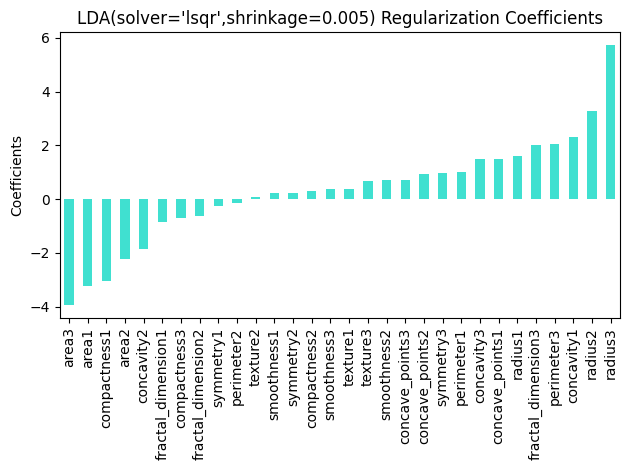


Accuracy score of LDA(solver="lsqr"): 	 0.9825
Number of features with coefs > 0.7: 	 19 



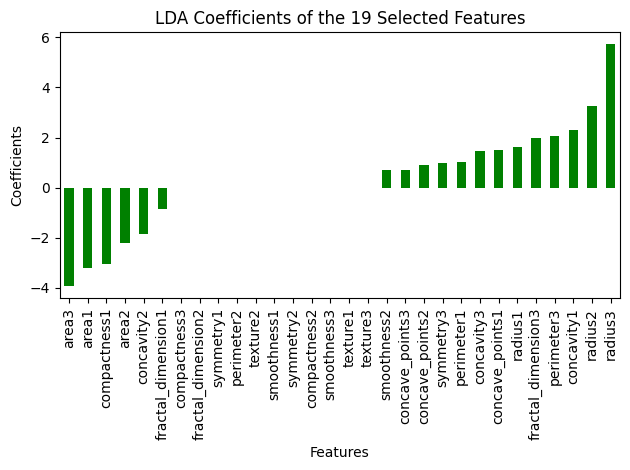


Example coefficients for radius1, radius2, radius3: 
radius1 coef: 	 1.619
radius2 coef: 	 3.28
radius3 coef: 	 5.72




<Figure size 640x480 with 0 Axes>

In [13]:
# Initialize LDA using 'lsqr' and fit to training data:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)

print('\n')
print('** NOTE: LDA does not drive coefficients to zero like Lasso (as seen above in block 4.1.1). **\n')
# Bar Plot of resulting COEF_s:
coefs = pd.Series(clf.coef_[0],X.columns).sort_values()
coefs.plot(kind='bar',color='turquoise')
plt.xticks(rotation=90)
plt.ylabel('Coefficients')
plt.title('LDA(solver=\'lsqr\',shrinkage=0.005) Regularization Coefficients')
plt.tight_layout()
plt.show()
plt.clf()

# Selecting features based on the absolute value of the coef_ compared to a threshold:
feature_names = list()
feature_values = list()
features_lda = 0
threshold = 0.7
for i in range(0,len(coefs)):
    if np.abs(coefs.iloc[i]) > threshold:
        feature_names.append(coefs.index[i])
        feature_values.append(coefs.iloc[i])
        features_lda += 1
    else:
        feature_names.append(coefs.index[i])
        feature_values.append(0)

print(f'\nAccuracy score of LDA(solver="lsqr"): \t {clf.score(X_test_scale,y_test):.4f}')
print('Number of features with coefs > 0.7: \t', features_lda,'\n')


# Plot of the 19 Features Selected by LDA:
plot_lda = pd.Series(feature_values,index=feature_names)
plot_lda.plot(kind='bar',color='green')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('LDA Coefficients of the 19 Selected Features')
plt.tight_layout()
plt.show()
plt.clf()

print('\nExample coefficients for radius1, radius2, radius3: ',)
print('radius1 coef: \t', coefs['radius1'].round(3))
print('radius2 coef: \t', coefs['radius2'].round(3))
print('radius3 coef: \t', coefs['radius3'].round(3))
print('\n')


## 4.2.2 Linear Discriminant Analysis – Feature Selection
*<div style="font-size:16px;color:lightpink"> *Note: Defining new LDA features training / testing sets as* **X_LDA_train** *and* **X_LDA_test** </div>*

In [14]:
# Initialize scaled training and testing data:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Initialize LDA and fit to training data:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)

# Define new training and testing sets as X_LDA_train, X_LDA_test
X_train_scale = pd.DataFrame(X_train_scale,columns=X.columns)
X_LDA_train = X_train_scale[X_train_scale.columns[np.abs(clf.coef_[0]) > 0.7]]
X_test_scale = pd.DataFrame(X_test_scale,columns=X.columns)
X_LDA_test = X_test_scale[X_test_scale.columns[np.abs(clf.coef_[0]) > 0.7]]

## DON'T fall for this trap!
# X_LDA_test = X_test_scale[X_test_scale.columns[coefs.abs() > 0.7]]
## Using coefs.abs() with load the incorrect features due to the sort_values() called on coefs.
## Instead reference the original clf.coef_ as it has maintained its index order.

## Checking for expected features
# print(X_LDA_train.head())
print('\n')
print('X_LDA_train shape:\t',X_LDA_train.shape)
print('X_LDA_test shape:\t',X_LDA_test.shape)



X_LDA_train shape:	 (455, 19)
X_LDA_test shape:	 (114, 19)


## 4.2.3. Linear Discriminant Analysis – Validating Feature Selection with RFC
*Runtime approx. 13 Seconds with 50 loops:*

In [15]:
# Compare the performance of RandomForestClassifier on X_LDA_train and X_LDA_test VS full feature set.
print('\n')
# Loop to fit RFC with LDA features and the Full features set, 50 times:
# About 15 sec runtime with 50 loop runs.
rfc_list = list()
for i in range(1,51):
    # LDA FEATURE SET:
    clf_validate1 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate1.fit(X_LDA_train,y_train)
    LDA_score = clf_validate1.score(X_LDA_test,y_test)
    # FULL FEATURE SET:
    clf_validate2 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND
    rfc_list.append([i+1,LDA_score,full_score])

c_names = ['random_state','LDA_score','full_score']
scores_df = pd.DataFrame(rfc_list,columns=c_names)
print(f'RFC LDA Avg Score: \t{scores_df["LDA_score"].mean():.4f}')
print(f'RFC Full Avg Score:\t{scores_df["full_score"].mean():.4f}')
print(f'RFC LDA Std Dev:   \t{scores_df["LDA_score"].std():.4f}')
print(f'RFC Full Std Dev:  \t{scores_df["full_score"].std():.4f}')

## The LDA feature set is underperforming compared to Lasso Features




RFC LDA Avg Score: 	0.9051
RFC Full Avg Score:	0.9225
RFC LDA Std Dev:   	0.0034
RFC Full Std Dev:  	0.0105


## 4.2.4. Linear Discriminant Analysis – Validating Feature Selection with SGDClassifier

In [16]:
# Compare the performance of SGDClassifier on X_LDA_train and X_LDA_test VS full feature set:
print('\n')
# Loop to fit SGDClassifier with LDA features and full features set, 50 times:
sgd_list = list()
for i in range(1,51):
    # Fit and score the LDA feature set:
    clf_validate1 = SGDClassifier(random_state=i+1,loss='log_loss',penalty='l2',alpha=0.01)
    clf_validate1.fit(X_LDA_train,y_train)
    LDA_score = clf_validate1.score(X_LDA_test,y_test)
    # Fit and score the full feature set:
    clf_validate2 = SGDClassifier(random_state=i+1,loss='log_loss',penalty='l2',alpha=0.01)
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND
    sgd_list.append([i+1,LDA_score,full_score])


c_names = ['random_state','LDA_score','full_score']
scores_df = pd.DataFrame(sgd_list,columns=c_names)
print(f'SGDC LDA Avg Score: \t{scores_df["LDA_score"].mean():.4f}')
print(f'SGDC Full Avg Score:\t{scores_df["full_score"].mean():.4f}')
print(f'SGDC LDA Std Dev:   \t{scores_df["LDA_score"].std():.4f}')
print(f'SGDC Full Std Dev:  \t{scores_df["full_score"].std():.4f}')

# The LDA feature set is underperforming compared to Lasso Features



SGDC LDA Avg Score: 	0.9691
SGDC Full Avg Score:	0.9889
SGDC LDA Std Dev:   	0.0054
SGDC Full Std Dev:  	0.0053


## 4.9. Prepare Classifier Switching Class:
*A helper class to allow for trialing multiple classifier models in one pipeline.*

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier

class ClfSwitch(BaseEstimator):
    def __init__(self, estimator=SGDClassifier()):
        self.estimator = estimator
    def fit(self,xx,yy=None,**kwargs):
        self.estimator.fit(xx,yy)
        return self
    def predict(self,xx,yy=None):
        return self.estimator.predict(xx)
    def predict_proba(self,xx,yy=None):
        return self.estimator.predict_proba(xx)
    def score(self,xx,yy):
        return self.estimator.score(xx,yy)

## 5. Define Pipeline / Preprocessor / Search_space

In [18]:
scaler = StandardScaler()

# Scale incoming data.
# No need to impute because data was verified as complete.
preprocessor = ColumnTransformer([
    ('scaler', scaler, X_train.columns)
])

# Define a pipeline for GridSearchCV and RandomizedSearchCV,
# using the preprocessor and ClfSwitch class defined above:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', ClfSwitch())
])

# Define search_space for use in GridSearchCV and RandomizedSearchCV.
# Lists all the possible parameter values to select/optimize:
search_space = [
    {'clf__estimator': [RandomForestClassifier(random_state=13)],
     'clf__estimator__max_depth':[10,15,25],
     'clf__estimator__n_estimators':[150,200,250],
     },
    {'clf__estimator': [GradientBoostingClassifier(random_state=13)],
     'clf__estimator__learning_rate':[0.001,0.01,0.1],
     'clf__estimator__n_estimators':[150,200,250],
     },
    {'clf__estimator': [SGDClassifier(random_state=13)],
     'clf__estimator__loss': ['hinge','log_loss'],
     'clf__estimator__alpha': [0.001,0.005,0.01],
     'clf__estimator__penalty': ['l2']
     }
]

## 6. GridSearchCV Implementation &#8594; Analyze Results and Prepare to Tune Hyperparameters
*About 30 sec runtime with current search_space (9,9,6)*

In [19]:
# USE sklearn version 1.5.2 to suppress FutureWarning during fit:
gs = GridSearchCV(estimator=pipeline, param_grid=search_space, cv=5, error_score='raise')
gs.fit(X_train, y_train)

# Load the best estimator:
gs_best = gs.best_estimator_

# Load the best classifier:
gs_best_clf = gs_best.named_steps['clf']

print('\n')
# Print the best classifier's estimator:
print(gs_best_clf.get_params()['estimator'])

## Parameters can be accessed using:
#print(gs_best_clf.get_params()['estimator__max_depth'])
#print(gs_best_clf.get_params()['estimator__n_estimators'])

# Compare the accuracy score on test data to the best_score_ (training data):
print(f'GSCV .score() (Test Data):\t\t{gs_best.score(X_test, y_test):.4f}')
print(f'GSCV .best_score_ (Training Data):\t{gs.best_score_:.4f}')



SGDClassifier(alpha=0.01, random_state=13)
GSCV .score() (Test Data):		0.9649
GSCV .best_score_ (Training Data):	0.9736


## 6.1. Feature Analysis using cv_results_

In [20]:
# Used .cv_results_ to create a dataframe of the results:
cv_df = pd.DataFrame(gs.cv_results_)

columns_interest = [
    'param_clf__estimator',
    'param_clf__estimator__max_depth',
    'param_clf__estimator__n_estimators',
    'param_clf__estimator__loss',
    'param_clf__estimator__penalty',
    'param_clf__estimator__alpha',
    'mean_test_score',
    'std_test_score',
    'rank_test_score']

cv_df_results = cv_df[columns_interest].round(3)
print('\n')
cv_df_results

,param_clf__estimator,param_clf__estimator__max_depth,param_clf__estimator__n_estimators,param_clf__estimator__loss,param_clf__estimator__penalty,param_clf__estimator__alpha,mean_test_score,std_test_score,rank_test_score
0,RandomForestClassifier(random_state=13),10.0,150.0,NaN,NaN,NaN,0.954,0.018,15
1,RandomForestClassifier(random_state=13),10.0,200.0,NaN,NaN,NaN,0.956,0.018,11
2,RandomForestClassifier(random_state=13),10.0,250.0,NaN,NaN,NaN,0.958,0.015,7
3,RandomForestClassifier(random_state=13),15.0,150.0,NaN,NaN,NaN,0.954,0.018,15
4,RandomForestClassifier(random_state=13),15.0,200.0,NaN,NaN,NaN,0.956,0.018,11
5,RandomForestClassifier(random_state=13),15.0,250.0,NaN,NaN,NaN,0.958,0.015,7
6,RandomForestClassifier(random_state=13),25.0,150.0,NaN,NaN,NaN,0.954,0.018,15
7,RandomForestClassifier(random_state=13),25.0,200.0,NaN,NaN,NaN,0.956,0.018,11
8,RandomForestClassifier(random_state=13),25.0,250.0,NaN,NaN,NaN,0.958,0.015,7
9,GradientBoostingClassifier(random_state=13),NaN,150.0,NaN,NaN,NaN,0.613,0.036,24


## 7. Hyperparameter Tuning and Retesting models
*Takeaways*
- SGDC outperforms RandomForestClassifier in both accuracy and runtime.
- SGDC performs best with loss='log_loss' and alpha=0.01
- RandomizedSearchCV is a non-exhaustive solution to finding good parameters in a defined number of iterations.
- SMOTE (Synthetic Minority Oversampling Technique) brings some moderate benefits to the SGDClassifier performance.

## 7.1. Diving Deeper into RandomForestClassifier Validation
*Using RandomForestClassifier(max_depth=10, n_estimators=150)*

In [21]:
# Modifying best rfc() to validate scores across dataset.
score_list = list()

scaler = StandardScaler()
scaler.fit(X)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Loop to analyze for any meaningful impact of Random_state on bootstrapping in the RFC().
for i in range(1,10):
    clf = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf.fit(X_train_scale,y_train)
    current_score = clf.score(X_test_scale,y_test)
    score_list.append([i+1,current_score])

print('\n')
c_names = ['random_state:','RFC score:']
score_df = pd.DataFrame(score_list,columns=c_names)
print(f'RFC Score Average:\t\t{score_df["RFC score:"].mean():.4f}')
print(f'RFC Score Std Deviation:\t{score_df["RFC score:"].std():.4f}')
# No indication that Random_state had a meaningful impact on our accuracy scores.

from time import perf_counter as tpc

start = tpc()
clf = RandomForestClassifier(random_state=11,max_depth=10,n_estimators=150)
clf.fit(X_train_scale,y_train)
current_score = clf.score(X_test_scale,y_test)
end = tpc()
print(f'\nRFC fit & score time: \t\t{((end - start) * 1000):.4f} ms')
print('\n')

score_df



RFC Score Average:		0.9250
RFC Score Std Deviation:	0.0146

RFC fit & score time: 		121.8394 ms




,random_state:,RFC score:
0,2,0.912281
1,3,0.912281
2,4,0.912281
3,5,0.921053
4,6,0.929825
5,7,0.929825
6,8,0.912281
7,9,0.947368
8,10,0.947368


## 7.2. Diving Deeper into SGDClassifier Validation – 'hinge' vs. 'log_loss'
*NOTE: Must scale data in this block because we are no longer using Pipeline and thus no preprocessor/scaler*
#### *Takeaway:*
- 'Log_Loss' outperforms 'hinge' as a loss parameter, with a higher average score (0.9895 vs. 0.9820)
- While maintaining scored std deviation at about 0.5% and run-time around 1 ms
- SGDClassifier SIGNIFICANTLY outperforms RandomForestClassifier for both score and run-time
- Even better results can be achieved using Lasso L1 Regularization / feature selection with SGDC (see block 4.1.X.)

In [22]:
# Modifying best SGDClassifier() to validate scores across dataset and compare loss='hinge' vs. loss='log_loss'
score_list = list()

# Cannot stress enough the importance of calling the scaler before fitting to SGDClassifer!
scaler = StandardScaler()
scaler.fit(X)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Loop to analyze for any meaningful impact of Random_state on SGDClassifier()
# Using alpha=0.01, penalty='l2'
for i in range(1,100):
    clf = SGDClassifier(random_state=i+1,loss='hinge',alpha=0.01,penalty='l2')
    clf.fit(X_train_scale,y_train)
    current_score = clf.score(X_test_scale,y_test)
    clf_log = SGDClassifier(random_state=i+1, loss='log_loss',alpha=0.01,penalty='l2')
    clf_log.fit(X_train_scale,y_train)
    current_score_log = clf_log.score(X_test_scale,y_test)
    score_list.append([i+1,current_score,current_score_log])

print('\n')
c_names = ['random_state:','SGDClassifier hinge score:','SGDClassifier log_loss score:']
score_df = pd.DataFrame(score_list,columns=c_names)
print(f'SGDC Hinge Score Average: \t\t{(score_df["SGDClassifier hinge score:"].mean()):.5f}')
print(f'SGDC Log_loss Score Average:\t\t{(score_df["SGDClassifier log_loss score:"].mean()):.5f}')
print(f'SGDC Hinge Score Std Deviation: \t{(score_df["SGDClassifier hinge score:"].std()):.5f}')
print(f'SGDC Log_loss Score Std Deviation:\t{(score_df["SGDClassifier log_loss score:"].std()):.5f}')
# No difference!

from time import perf_counter as tpc

start = tpc()
clf = SGDClassifier(random_state=11,loss='hinge',alpha=0.01,penalty='l2')
clf.fit(X_train_scale,y_train)
current_score = clf.score(X_test_scale,y_test)
end = tpc()
print(f'\nSGDC "Hinge" fit & score time:\t\t{((end - start) * 1000):.4f} ms')


start = tpc()
clf_log = SGDClassifier(random_state=11, loss='log_loss',alpha=0.01,penalty='l2')
clf_log.fit(X_train_scale,y_train)
current_score_log = clf.score(X_test_scale,y_test)
end = tpc()
print(f'SGDC "Log_loss" fit & score time:\t{((end - start) * 1000):.4f} ms')
print('\n')

# score_df



SGDC Hinge Score Average: 		0.98201
SGDC Log_loss Score Average:		0.98954
SGDC Hinge Score Std Deviation: 	0.00691
SGDC Log_loss Score Std Deviation:	0.00463

SGDC "Hinge" fit & score time:		0.9223 ms
SGDC "Log_loss" fit & score time:	1.0485 ms




## 7.3. RandomizedSearchCV Implementation
*Note: Runtime benefits from defining n_iter parameter (default n_iter=10)*

*When n_iter=5 the Runtime is 5 to 8 seconds, when n_iter=10 the Runtime is 8 to 18 seconds*

In [23]:
# RandomizedSearchCV method:
from sklearn.model_selection import RandomizedSearchCV

## No need to initialize scaler here, the pipeline handles a preprocessor scaler.
# Re-defining search_space for use in RandomizedSearchCV.
search_space = [
    {'clf__estimator': [RandomForestClassifier(random_state=13)],
     'clf__estimator__max_depth':[10,15,25],
     'clf__estimator__n_estimators':[150,200,250],
     },
    {'clf__estimator': [GradientBoostingClassifier(random_state=13)],
     'clf__estimator__learning_rate':[0.001,0.01,0.1],
     'clf__estimator__n_estimators':[150,200,250],
     },
    # Added more parameters to search_space for SGDClassifier:
    {'clf__estimator': [SGDClassifier(random_state=13)],
     'clf__estimator__loss': ['hinge','log_loss'],
     'clf__estimator__alpha': [0.0001,0.0005,0.001,0.005,0.01],
     'clf__estimator__penalty': ['l2','elasticnet']
     }
]

print('\n')
rs = RandomizedSearchCV(random_state=13,estimator=pipeline,
                        param_distributions=search_space,
                        cv=5, n_iter=15, error_score='raise')
rs.fit(X_train, y_train)

# Load the best estimator:
rs_best = rs.best_estimator_
# Load the best classifier:
rs_best_clf = rs_best.named_steps['clf']
# Print the best classifier's estimator:
print(rs_best_clf.get_params()['estimator'])

# Compare the test data score to the training data (best_score_):
print(f'RandomizedSearchCV Best test score: \t{rs_best.score(X_test, y_test):.4f}')
print(f'RandomizedSearchCV Best training score:\t{rs.best_score_:.4f}')

# Load cv_results_ into a dataframe:
rs_cv = pd.DataFrame(rs.cv_results_)
columns_of_interest = [
    'param_clf__estimator',
    'param_clf__estimator__loss',
    'param_clf__estimator__penalty',
    'param_clf__estimator__alpha',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]
rs_result = rs_cv[columns_of_interest].round(5)
rs_result



SGDClassifier(alpha=0.005, loss='log_loss', penalty='elasticnet',
              random_state=13)
RandomizedSearchCV Best test score: 	0.9649
RandomizedSearchCV Best training score:	0.9780


,param_clf__estimator,param_clf__estimator__loss,param_clf__estimator__penalty,param_clf__estimator__alpha,mean_test_score,std_test_score,rank_test_score
0,SGDClassifier(random_state=13),hinge,elasticnet,0.0100,0.96923,0.02014,3
1,RandomForestClassifier(random_state=13),NaN,NaN,NaN,0.95604,0.01839,10
2,SGDClassifier(random_state=13),log_loss,elasticnet,0.0050,0.97802,0.00983,1
3,SGDClassifier(random_state=13),hinge,elasticnet,0.0005,0.96484,0.02131,7
4,SGDClassifier(random_state=13),hinge,elasticnet,0.0001,0.96703,0.01839,6
5,RandomForestClassifier(random_state=13),NaN,NaN,NaN,0.95385,0.01758,12
6,SGDClassifier(random_state=13),log_loss,l2,0.0050,0.97363,0.00879,2
7,RandomForestClassifier(random_state=13),NaN,NaN,NaN,0.95604,0.01839,10
8,GradientBoostingClassifier(random_state=13),NaN,NaN,NaN,0.95385,0.01891,12
9,RandomForestClassifier(random_state=13),NaN,NaN,NaN,0.95385,0.01758,12


## 7.4. Retesting with SMOTE – Synthetic Minority Oversampling Technique
- DEFINED new variables: **X_res** and **y_res** from SMOTE fit_resample() <br><br>
- Allows for synthetic data insertion to better 'balance' the data
- Using parameter 'sampling_strategy' as a float (ratio) – Note: this only works for binary classification.



Original Training Data Shape: 	(455, 30)
Original Training target (y) values: 
Diagnosis
0    279
1    176
Name: count, dtype: int64

// Synthetic samples created (sampling_strategy=0.77): 38 //
-----------------------
// Synthetic samples created (sampling_strategy=0.88): 69 //
-----------------------
// Synthetic samples created (sampling_strategy=0.99): 100 //
-----------------------
SMOTE Training Data Shape:	(555, 30)
SMOTE Resampled target (y) values:
Diagnosis
0    279
1    276
Name: count, dtype: int64



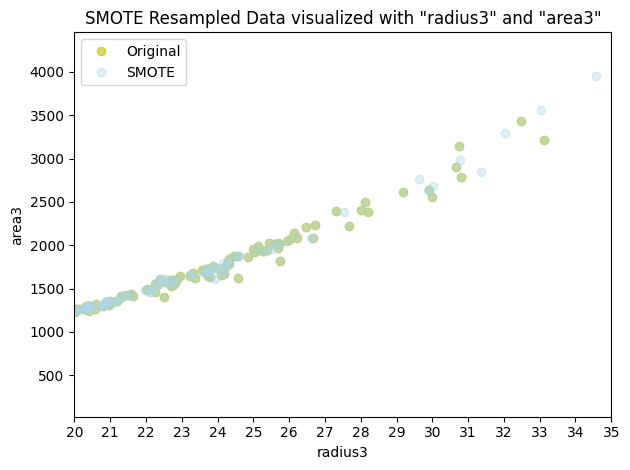

<Figure size 640x480 with 0 Axes>

In [24]:
from imblearn.over_sampling import SMOTE

print('\n')
print(f'Original Training Data Shape: \t{X_train.shape}')
print(f'Original Training target (y) values: \n{y_train.value_counts()}\n')

for i in [0.77,0.88,0.99]:
    smote = SMOTE(random_state=13,sampling_strategy=i,k_neighbors=5)
    X_res, y_res = smote.fit_resample(X_train,y_train)
    # print(f'SMOTE Resampled Data Shape:\t{X_res.shape}')
    # print(f'SMOTE target values: \n{y_res.value_counts()}')
    print(f'// Synthetic samples created (sampling_strategy={i}): '
          f'{X_res.shape[0] - X_train.shape[0]} //')
    print('-----------------------')

print(f'SMOTE Training Data Shape:\t{X_res.shape}')
print(f'SMOTE Resampled target (y) values:\n{y_res.value_counts()}\n')

## Visualizing the new synthetic data points on a plot
# ORIGINAL TRAINING SET PLOT RADIUS3 AND AREA3 // GREEN
plt.plot(X_train.radius3, X_train.area3, 'o', alpha=0.6,color='y')

# SMOTE TRAINING SET PLOT RADIUS3 AND AREA3 // RED
plt.plot(X_res.radius3, X_res.area3, 'o', alpha=0.4,color='lightblue')
plt.xlabel('radius3')
plt.ylabel('area3')
plt.title('SMOTE Resampled Data visualized with "radius3" and "area3"')
plt.xlim(20,35)
plt.xticks(np.arange(20,36,1))
plt.tight_layout()
plt.legend(['Original','SMOTE'])
plt.show()
plt.clf()

## 7.4.1. Retesting with SMOTE – Full feature set VS. Lasso feature set

#### *Takeaways:*
- SMOTE underperforms on the full data set, likely due to increased sample noise on "unimportant" features
- SMOTE shines with Lasso features, beating the previous best score using SGDC with Lasso (0.9911 vs. 0.9846)
- Std deviation is approaching 0.1%
- BEST SCORE YET achieved using SMOTE w/ Lasso feature set and increasing SGDC alpha from (0.01) to (0.1) → 0.9912 accuracy
- However, overfitting / underfitting should be called into question as the training and testing scores diverge

In [25]:
# Initialized SMOTE and Scaler to prevent cell rerun ValueErrors when trialing
# SMOTE 'sampling_strategies' values
smote = SMOTE(random_state=13,sampling_strategy=0.99,k_neighbors=5)
X_res, y_res = smote.fit_resample(X_train,y_train)

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)
X_res_scale = scaler.transform(X_res)

# Loop to store score results, comparing Full feature set original data vs. SMOTE data
compare_smote_list = list()
for i in range(1,51):
    clf = SGDClassifier(random_state=i+1,loss='log_loss',alpha=0.01,penalty='l2')
    clf.fit(X_train_scale,y_train)
    original_score = clf.score(X_test_scale,y_test)
    clf.fit(X_res_scale,y_res)
    smote_score = clf.score(X_test_scale,y_test) # X_test_scale is untouched by SMOTE
    compare_smote_list.append([i,original_score,smote_score])


c_names = ['random_state','original_score','smote_score']
compare_smote_df = pd.DataFrame(compare_smote_list,columns=c_names)
print('\n// FULL Feature Set (30 features) - Original data vs. SMOTE data:')
print(f'Original Score Average:\t\t{compare_smote_df["original_score"].mean():.4f}')
print(f'SMOTE Score Average: \t\t{compare_smote_df["smote_score"].mean():.4f}')
print(f'Original Score Std Deviation:\t{compare_smote_df["original_score"].std():.4f}')
print(f'SMOTE Score Std Deviation: \t{compare_smote_df["smote_score"].std():.4f}')
# There is no immediate obvious benefit to using SMOTE, lower average scores.

# X_L_train and X_L_test are scaled above in block 4.X.
smote = SMOTE(random_state=13,sampling_strategy=0.99,k_neighbors=5)
X_L_res, y_res = smote.fit_resample(X_L_train,y_train)

# Loop to store score results, comparing Lasso feature sets original data vs. SMOTE data
compare_smote_L_list = list()
for i in range(1,51):
    clf = SGDClassifier(random_state=i+1,loss='log_loss',alpha=0.01,penalty='l2')
    clf.fit(X_L_train,y_train)
    original_score= clf.score(X_L_test,y_test)
    clf.fit(X_L_res,y_res)
    smote_L_score = clf.score(X_L_test,y_test)
    compare_smote_L_list.append([i,original_score,smote_L_score])

c_names = ['random_state','original_score','smote_L_score']
compare_smote_L_df = pd.DataFrame(compare_smote_L_list,columns=c_names)
print('\n// Lasso Feature Set (19 features) - Original data vs. SMOTE data:')
print(f'Original Score Average:\t\t{compare_smote_L_df["original_score"].mean():.4f}')
print(f'SMOTE Score Average: \t\t{compare_smote_L_df["smote_L_score"].mean():.4f}')
print(f'Original Score Std Deviation:\t{compare_smote_L_df["original_score"].std():.4f}')
print(f'SMOTE Score Std Deviation: \t{compare_smote_L_df["smote_L_score"].std():.4f}')
print(f'\nSMOTE final loop training score: {clf.score(X_L_res,y_res):.4f}')


// FULL Feature Set (30 features) - Original data vs. SMOTE data:
Original Score Average:		0.9889
SMOTE Score Average: 		0.9775
Original Score Std Deviation:	0.0053
SMOTE Score Std Deviation: 	0.0051

// Lasso Feature Set (19 features) - Original data vs. SMOTE data:
Original Score Average:		0.9909
SMOTE Score Average: 		0.9911
Original Score Std Deviation:	0.0017
SMOTE Score Std Deviation: 	0.0012

SMOTE final loop training score: 0.9838


## 8. FINAL Pipeline Assembly and Validation:
*Takeaways*
- To use Sklearn.Pipeline, helper classes must be defined for Lasso and SMOTE (add transform method)
- Defining a get_shape() method aids in visualizing the transformation of data in the Pipeline.
- The Pipeline is highly performant and does not appear to suffer from overfitting (see block 8.3).

## 8.1. FINAL Pipeline - Helper Classes (LASSO & SMOTE)

In [26]:
from sklearn.base import BaseEstimator,TransformerMixin

# Lasso helper class to add the transform function for sklearn.pipeline
class LassoFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,alpha=0.05, lasso_threshold=0.001):
        self.mask_ = None
        self.lasso_ = None
        self.alpha = alpha
        self.lasso_threshold = lasso_threshold
        self.shape_ = None

    def fit(self, xx, yy=None):
        self.lasso_ = Lasso(alpha=self.alpha)
        self.lasso_.fit(xx, yy)
        self.mask_ = np.where(np.abs(self.lasso_.coef_) > self.lasso_threshold, True, False)
        if not self.mask_.any():
            raise ValueError('No features were selected: Try lowering the threshold or alpha.')
        return self

    def transform(self, xx):
        if isinstance(xx, pd.DataFrame):
            self.shape_ = xx.loc[:, X.columns[self.mask_]].shape
            return xx.loc[:, X.columns[self.mask_]]
        else:
            self.shape_ = xx[:, self.mask_].shape
            return xx[:, self.mask_]

    def get_shape(self):
        return self.shape_

# SMOTE helper class to add the transform function for sklearn.pipeline
# Note that transform() is not needed for SMOTE, as it is a fit_resample() method.
# Additionally, we do NOT want to transform/resample the incoming test data!
class SyntheticDataBalance(BaseEstimator,TransformerMixin):
    def __init__(self,sampling_strategy=0.99,k_neighbors=5):
        self.sampling_strategy = sampling_strategy
        self.k_neighbors = k_neighbors
        self.smote = SMOTE(random_state=13,sampling_strategy=sampling_strategy,k_neighbors=k_neighbors)
        self.xx_res_ = None
        self.yy_res_ = None

    def fit(self, xx, yy):
        if yy.nunique() != 2:
            raise ValueError('Target must be binary to utilize SMOTE sampling_strategy.')
        self.xx_res_, self.yy_res_ = self.smote.fit_resample(xx, yy)
        return self

    # transform method returns X_test data without resampling
    def transform(self, xx):
        return xx

    def get_shape(self):
        return self.xx_res_.shape


## 8.2. FINAL Pipeline – Defining the Pipeline

In [27]:
# Defining preprocessor, search_space, and pipeline:
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X_train.columns)
])

search_space = [
    {'clf__loss': ['hinge','log_loss'],
     'clf__alpha': [0.001,0.005,0.01]},
    {'lassofeatures__alpha': [0.001,0.005,0.01]},
    {'smote__k_neighbors': [3,5,7],
     'smote__sampling_strategy': [0.77,0.88,0.99]}
]

pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('lassofeatures', LassoFeatures(alpha=0.005, lasso_threshold=0.001)),
    ('smote', SyntheticDataBalance(sampling_strategy=0.99,k_neighbors=5)),
    ('clf', SGDClassifier(random_state=13))
])

rs = RandomizedSearchCV(random_state=13,estimator=pipeline,param_distributions=search_space,cv=5, n_iter=10, error_score='raise')
rs.fit(X_train, y_train)
rs_best = rs.best_estimator_


## 8.3. FINAL Pipeline – Visualizing the flow of data through the Pipline

In [28]:
# Print statements to visualize the pipeline steps:
# print(rs_best.named_steps['lassofeatures'].lasso_.coef_)
print('\n')
print('Pipeline Steps: '
      '\nPreprocessor (Scale/Impute) --> LASSO Features Selection --> SMOTE --> SGDClassifier'
      '\n\nNote: SHAPE (rows, columns)')

print('---------------------------------------------------')

print('SHAPE After Scale, Before LASSO: ', X_train.shape,
      '\t// All 30 features and 455 training samples.')

print('SHAPE After LASSO, Before SMOTE: ',rs_best.named_steps['lassofeatures'].get_shape(),
      '\t// Lasso removes 11 features.')

print('SHAPE After SMOTE, Before SGDCl: ',rs_best.named_steps['smote'].get_shape(),
      '\t// SMOTE adds 100 synthetic samples.')

print(f'\n*NOTE: SMOTE added 100 synthetic samples to balance the training data.')

print(f'\nLASSO parameters: \n\talpha: {rs_best.named_steps["lassofeatures"].alpha}')

print(f'\nSMOTE parameters: \n\tsampling_strategy: {rs_best.named_steps["smote"].sampling_strategy} '
      f'\n\tk_neighbors: {rs_best.named_steps["smote"].k_neighbors}')

print(f'\nSGDClassifier parameters: \n\tloss: {rs_best.named_steps['clf'].loss} '
      f'\n\talpha: {rs_best.named_steps["clf"].alpha}')

# Maintain this order for printing scores:
print(f'\nPipeline Testing Set Score:  {rs_best.score(X_test,y_test):.4f}'
      f'\nPipeline Training Set Score: {rs_best.score(X_train,y_train):.4f}'
      f'\nPipeline CV Training Score:  {rs.best_score_:.4f}')



Pipeline Steps: 
Preprocessor (Scale/Impute) --> LASSO Features Selection --> SMOTE --> SGDClassifier

Note: SHAPE (rows, columns)
---------------------------------------------------
SHAPE After Scale, Before LASSO:  (455, 30) 	// All 30 features and 455 training samples.
SHAPE After LASSO, Before SMOTE:  (455, 19) 	// Lasso removes 11 features.
SHAPE After SMOTE, Before SGDCl:  (555, 19) 	// SMOTE adds 100 synthetic samples.

*NOTE: SMOTE added 100 synthetic samples to balance the training data.

LASSO parameters: 
	alpha: 0.005

SMOTE parameters: 
	sampling_strategy: 0.99 
	k_neighbors: 5

SGDClassifier parameters: 
	loss: log_loss 
	alpha: 0.01

Pipeline Testing Set Score:  0.9912
Pipeline Training Set Score: 0.9824
Pipeline CV Training Score:  0.9714
